# Laboratory Exercise 3: Data Augmentation for Improving Model Generalization

**Name:** Lorenzo Bela, Robert Callorina, Kean Guzon

**Section:** 58036

**Date:** February 3 2026

**Dataset:** CIFAR-10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

## Part B: Load Preprocessed Dataset from Lab 2

In [ ]:
images = np.load('../../lab02_data_cleaning/data/processed/images_64x64.npy')
labels = np.load('../../lab02_data_cleaning/data/processed/labels.npy')

np.random.seed(42)
total_samples = len(images)
sample_indices = np.random.choice(total_samples, min(5000, total_samples), replace=False)

images = images[sample_indices]
labels = labels[sample_indices]

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Total samples loaded: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Data type: {images.dtype}")
print(f"Value range: [{images.min()}, {images.max()}]")
print(f"Class names: {class_names}")

100%|██████████| 170M/170M [00:55<00:00, 3.09MB/s] 


Total samples in dataset: 50000
Using sample size: 5000
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Image size: (32, 32, 3)
Data type: uint8


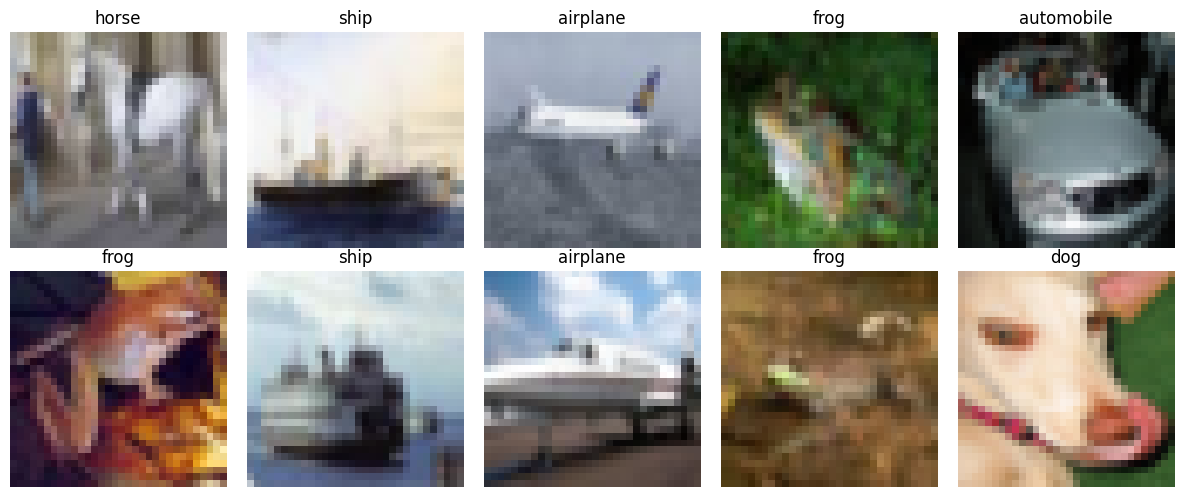

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img = (images[i] * 255).astype('uint8')
    ax.imshow(img)
    ax.set_title(class_names[labels[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
for i in range(50):
    img = (images[i] * 255).astype('uint8')
    Image.fromarray(img).save(f'../data/raw/raw_{i}.png')

## Part C: Define Augmentation Pipeline

In [4]:
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Pad(padding=4),
    transforms.RandomCrop(size=32),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomGrayscale(p=0.1)
])

print("Augmentation pipeline created")

Augmentation pipeline created


## Part D: Visualize Augmentations

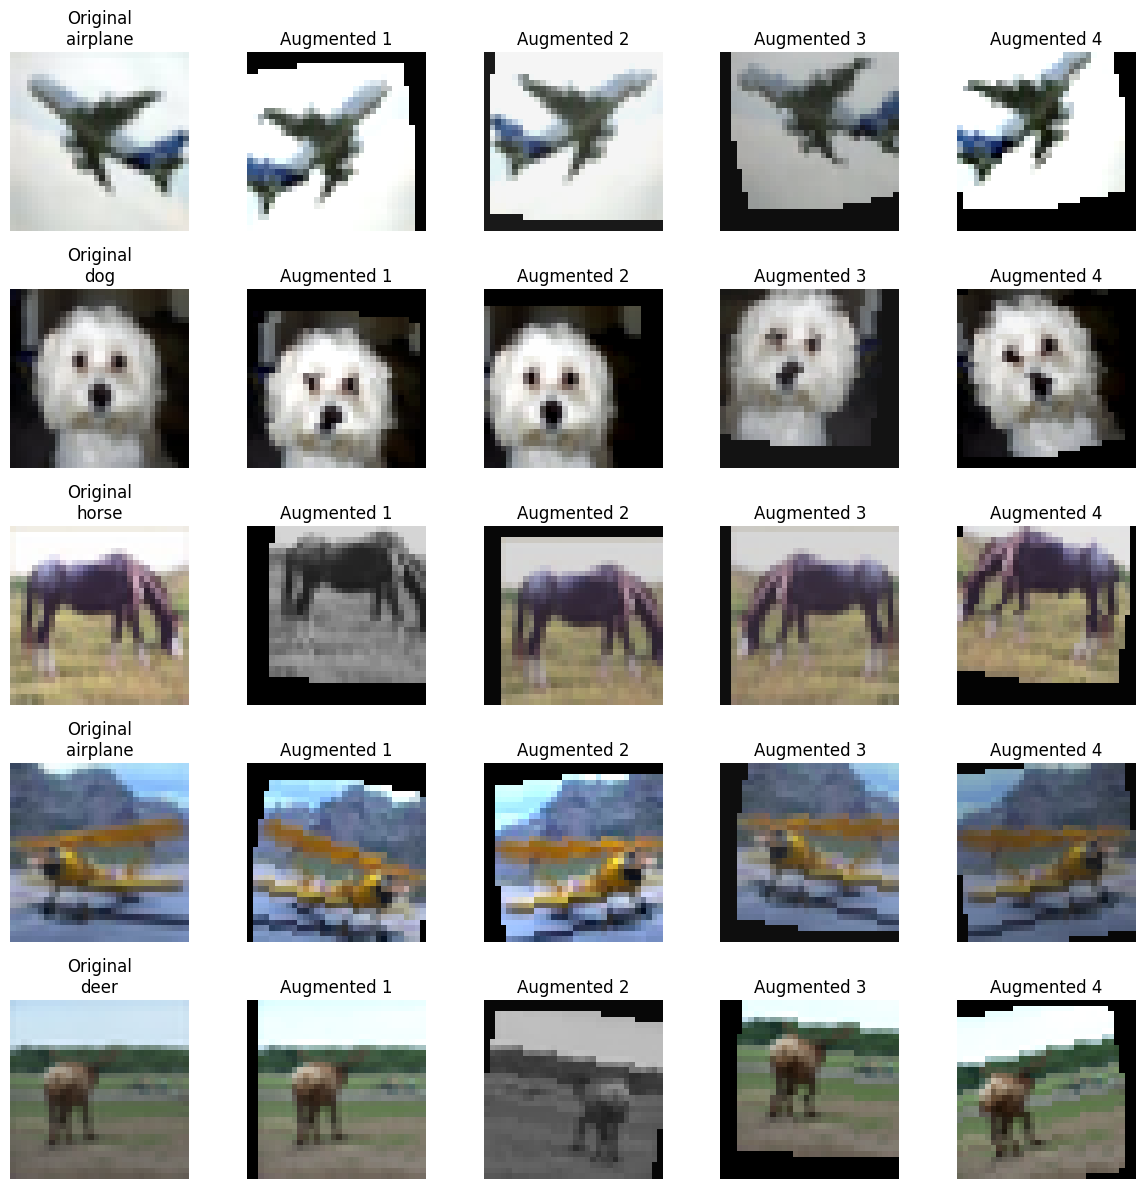

In [ ]:
np.random.seed(42)
vis_indices = np.random.choice(len(images), 5, replace=False)

fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for row in range(5):
    idx = vis_indices[row]
    img_array = (images[idx] * 255).astype('uint8')
    img = Image.fromarray(img_array)
    label = labels[idx]
    
    axes[row, 0].imshow(img_array)
    axes[row, 0].set_title(f'Original\n{class_names[label]}')
    axes[row, 0].axis('off')
    
    torch.manual_seed(row)
    for col in range(1, 5):
        aug_img = augmentation(img)
        axes[row, col].imshow(aug_img)
        axes[row, col].set_title(f'Augmented {col}')
        axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('../outputs/figures/lab03_augmentation_examples.png')
plt.show()

In [ ]:
for i in range(50):
    img_array = (images[i] * 255).astype('uint8')
    img = Image.fromarray(img_array)
    
    aug_flip = transforms.RandomHorizontalFlip(p=1.0)(img)
    aug_flip.save(f'../data/processed/aug_flip_{i}.png')
    
    aug_rotate = transforms.RandomRotation(degrees=15)(img)
    aug_rotate.save(f'../data/processed/aug_rotate_{i}.png')
    
    aug_crop = transforms.Compose([transforms.Pad(4), transforms.RandomCrop(32)])(img)
    aug_crop.save(f'../data/processed/aug_crop_{i}.png')
    
    aug_color = transforms.ColorJitter(brightness=0.3, contrast=0.3)(img)
    aug_color.save(f'../data/processed/aug_color_{i}.png')

## Part E: Augmentation Summary Logging

In [6]:
log_text = """Augmentation Configuration Summary

List of augmentations used:
1. Random Horizontal Flip
2. Random Rotation
3. Random Crop with Padding
4. Color Jitter
5. Random Grayscale

Parameters:
- Rotation angle range: ±15 degrees
- Crop size: 32x32
- Padding: 4 pixels
- Flip probability: 0.5
- Color jitter brightness: 0.2
- Color jitter contrast: 0.2
- Grayscale probability: 0.1
"""

with open('../outputs/logs/lab03_augmentation_config.txt', 'w') as f:
    f.write(log_text)

print("Augmentation configuration saved")

Augmentation configuration saved


## Part F: Dataset Balance Check

In [ ]:
counts = pd.Series(labels).value_counts().sort_index()
counts.index = [class_names[i] for i in counts.index]

print("Class Distribution:")
print(counts)

counts.to_csv('../outputs/tables/lab03_class_distribution.csv')
print("\nClass distribution saved")

Class Distribution:
airplane      476
automobile    487
bird          527
cat           523
deer          486
dog           504
frog          485
horse         509
ship          503
truck         500
Name: count, dtype: int64

Class distribution saved


**Why augmentation does not change class distribution:**

Data augmentation applies transformations to existing images during training but does not create new permanent samples in the dataset. The augmentations happen on-the-fly, so the original class distribution counts remain the same. Each original image still has its original label, and augmented versions are just temporary variations of the same image with the same label.

## Results and Discussion

### A. Augmentation Pipeline Design

**Augmentations used:**

1. **Random Horizontal Flip** - Helps the model learn that objects can appear facing left or right, improving generalization to different orientations.

2. **Random Rotation (±15 degrees)** - Teaches the model to recognize objects at slight angles, making it robust to camera tilt or object orientation.

3. **Random Crop with Padding** - Simulates different viewpoints and scales, helping the model focus on object features rather than exact positioning.

4. **Color Jitter** - Makes the model robust to different lighting conditions and camera settings by varying brightness and contrast.

5. **Random Grayscale** - Occasionally converts images to grayscale, forcing the model to learn shape features instead of relying only on color.

### B. Visual Evidence

The saved augmentation figure shows the original images alongside four augmented versions. The variations include rotations, flips, brightness changes, and crops while keeping the object recognizable.

### C. Appropriateness of Augmentation

**Safe augmentations for CIFAR-10:**
1. Horizontal flip - Objects like cars, planes, and ships can face either direction
2. Small rotations - Real-world objects can be tilted slightly

**Potentially unsafe augmentation:**
Vertical flip could be unsafe for some classes. For example, flipping a horse or truck upside down would create unrealistic images that don't represent real-world scenarios.

### D. Expected Effect on Training

Augmentation reduces overfitting by showing the model different variations of each image. This means the model cannot memorize exact pixel patterns. We expect training accuracy to be slightly lower because the task is harder, but validation accuracy should be higher because the model learns more generalizable features instead of memorizing the training set.

## Questions (Answer Individually)

**1. What is data augmentation and why is it commonly used in perception tasks?**

Data augmentation is the process of creating modified versions of training images using transformations that preserve the label. It is commonly used in perception tasks because it helps prevent overfitting by teaching the model to recognize objects under different conditions like lighting, angles, and positions, without needing to collect more real data.

**2. Give three examples of augmentations that are usually label-preserving for object classification.**

- Horizontal flip: The object remains the same just facing the opposite direction
- Small rotation: The object is still the same just tilted slightly
- Brightness adjustment: The object looks the same under different lighting

**3. What is one example of an augmentation that can break labels for some tasks? Explain.**

Vertical flip can break labels for tasks involving text recognition or digit classification. For example, flipping the number 6 upside down makes it look like a 9, which changes its label. Similarly, most real-world objects like cars and animals are never seen upside down.

**4. Why is on-the-fly augmentation preferred over saving all augmented images in many projects?**

On-the-fly augmentation saves storage space because you don't need to store thousands of augmented images on disk. It also provides more variety because each epoch can generate different random augmentations of the same image, rather than using the same fixed augmented versions every time.

**5. If your model overfits heavily, how can augmentation help? Give a practical explanation.**

If a model overfits, it means it memorized the exact appearance of training images instead of learning general features. Augmentation forces the model to see different versions of each image in every epoch, so it cannot memorize specific pixel patterns. Instead, it must learn the actual object features that remain consistent across all the augmented variations.

## Conclusion

In this lab, we implemented a data augmentation pipeline for CIFAR-10 using five transformations: random horizontal flip, rotation (±15°), crop with padding, color jitter, and random grayscale. The visualizations confirm that augmentations produce realistic variations while keeping objects recognizable and labels intact.

The class distribution analysis shows that augmentation does not change the number of samples per class because transformations are applied on-the-fly during training rather than creating permanent new samples.

Data augmentation is essential before training CNNs because it prevents overfitting by exposing the model to diverse variations of the training data. This helps the model learn robust features that generalize well to new, unseen images instead of memorizing the exact appearance of training samples.